# Capstone Project

*add description here*

## Checkpoint 2

*add description here*

### Task 2.2 Exploratory Data Analysis

*add description here*

#### Import required Libraries

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
pd.options.display.float_format = '{:.2f}'.format
import matplotlib.pyplot as plot
from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder
from sklearn.decomposition import PCA

#### Prepare the table

1) Import all csv / excel files
2) Merge files into single dataframe

In [2]:
# 1) Import all csv.excel files
sales = pd.read_csv('Car_sales_transactions.csv')
city = pd.read_excel('City_Master.xlsx')
# postal_code = pd.read_excel('Postal_Code_Master.xlsx')
#TODO
region = pd.read_excel('Region_Master.xlsx')
region_state = pd.read_excel('Region_State_Mapping.xlsx')
sales_status = pd.read_csv('Sales_Status.csv')
state = pd.read_excel('State_Master.xlsx')

#2) Merge all files into single dataframe
df = sales.copy()
df = pd.merge(df,city[['City_Code','City_Name']],on='City_Code',how='left')
df = pd.merge(df,region_state,on='State_Code',how='left')
df = pd.merge(df,region,on=['Region_Code'])
df = pd.merge(df,sales_status,on='Sales_ID',how='left')
df = pd.merge(df,state,on='State_Code',how='left')

#3) Amend Columns to get information
df['company'] = df['Name'].str.split(expand=True,pat=" ")[0]
df['engine_cc'] = df['Engine'].str.split(pat=" ",expand=True)[0].astype(int)
df['max_power_bhp'] = df['Max_Power'].str.split(pat=" ",expand=True)[0].astype('float')

df['sold'] = np.where(df['Sold']=='Y',True,False)

df['mileage'] = df['Mileage'].str.split(pat=" ",expand=True)[0].astype('float')
fuel_cost = {'Diesel':86.71, 'Petrol':97.76, 'LPG':52.50, 'CNG':43.4}
df['fuel_cost'] = df['Fuel'].map(fuel_cost)
df['mileage_per100bucks'] = round(df['mileage'] *100 / df['fuel_cost'],2)
df['age'] = df['Year'] - df['Year'].max()

df.drop(columns=['Max_Power','Mileage','mileage',
    'fuel_cost','Engine','State_Code','Sales_ID',
    'City_Code','Region_Code','Sold','Year','Postal_Code',
    'State_Name','Region'],inplace=True)
df.head(3)

,Name,Selling_Price,km_Driven,Fuel,Seller_Type,Transmission,Owner,Seats,City_Name,company,engine_cc,max_power_bhp,sold,mileage_per100bucks,age
0,Maruti Swift Dzire VDI,450000,145500,Diesel,Individual,Manual,First Owner,5,Mumbai,Maruti,1248,74.00,True,26.99,-6
1,Maruti 800 DX BSII,45000,5000,Petrol,Individual,Manual,Second Owner,4,Pune,Maruti,796,37.00,True,16.47,-19
2,Toyota Etios VXD,350000,90000,Diesel,Individual,Manual,First Owner,5,Aurangabad,Toyota,1364,67.10,True,27.21,-9


In [3]:
df.columns

Index(['Name', 'Selling_Price', 'km_Driven', 'Fuel', 'Seller_Type',
       'Transmission', 'Owner', 'Seats', 'City_Name', 'company', 'engine_cc',
       'max_power_bhp', 'sold', 'mileage_per100bucks', 'age'],
      dtype='object')

#### Data Exploration and Cleaning

1) Data Describe
2) Check for outliers
    1) km_Driven
    2) engine_cc
    3) max_power_bhp
    4) mileage_per100bucks
3) Create Dummies for categorical features:
    1) Postal_Code
    2) Fuel
    3) Seller_Type
    4) Transmission
    5) Owner
    6) Seats
    7) City_Name
    8) Region
    9) State_Name
    10) company
    


In [4]:
df.describe(include='all')

,Name,Selling_Price,km_Driven,Fuel,Seller_Type,Transmission,Owner,Seats,City_Name,company,engine_cc,max_power_bhp,sold,mileage_per100bucks,age
count,7906,7906.00,7906.00,7906,7906,7906,7906,7906.00,7906,7906,7906.00,7906.00,7906,7906.00,7906.00
unique,1982,NaN,NaN,4,3,2,5,NaN,29,31,NaN,NaN,2,NaN,NaN
top,Maruti Swift Dzire VDI,NaN,NaN,Diesel,Individual,Manual,First Owner,NaN,Delhi,Maruti,NaN,NaN,False,NaN,NaN
freq,129,NaN,NaN,4299,6563,6865,5215,NaN,320,2367,NaN,NaN,5906,NaN,NaN
mean,NaN,649813.72,69188.66,NaN,NaN,NaN,NaN,5.42,NaN,NaN,1458.71,91.59,NaN,21.54,-6.02
std,NaN,813582.75,56792.30,NaN,NaN,NaN,NaN,0.96,NaN,NaN,503.89,35.75,NaN,5.69,3.86
min,NaN,29999.00,1.00,NaN,NaN,NaN,NaN,2.00,NaN,NaN,624.00,32.80,NaN,0.00,-26.00
25%,NaN,270000.00,35000.00,NaN,NaN,NaN,NaN,5.00,NaN,NaN,1197.00,68.05,NaN,17.97,-8.00
50%,NaN,450000.00,60000.00,NaN,NaN,NaN,NaN,5.00,NaN,NaN,1248.00,82.00,NaN,20.77,-5.00
75%,NaN,690000.00,95425.00,NaN,NaN,NaN,NaN,5.00,NaN,NaN,1582.00,102.00,NaN,24.50,-3.00


Few Points to note here:
* There are total 7906 records and no feature has NULL values
* Name: str - has 'Maruti Swift Dzire VDI' as top value
* Year: int - Starts from 1994 upto 2020. Higher Better
* Selling_Price: int - Left skewed.
* km_Driven: int - Left Skewed. Lower Better
* Fuel: str - ['Diesel', 'Petrol', 'LPG', 'CNG']
* Seller_Type: str - ['Individual', 'Dealer', 'Trustmark Dealer']
* Transmission: str - ['Manual' 'Automatic']
* Owner: str - ['First Owner' 'Second Owner' 'Third Owner' 'Fourth & Above Owner','Test Drive Car']
* Seats: int - [ 2  4  5  6  7  8  9 10 14]
* City_Name: str - Top Delhi
* Region: str - Top South
* sold: Boolean - True/False
* State_Name: str - Top Tamil Nadu
* company: str - Top Maruti, 31 unique companies
* engine_cc: int - Left Skewed. Higher Better
* max_power_bhp: float - Left Skewed. Higher Better
* mileage_per100bucks: float - Normal

<AxesSubplot:>

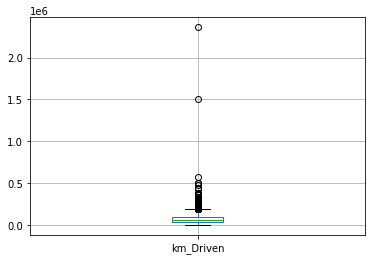

In [5]:
# Checking for Outliers
#km_Driven

col = 'km_Driven'
df.boxplot(column=col)

In [6]:
df[col].sort_values(ascending=False)

2172    2360457
3170    1500000
679      577414
5270     500000
3838     500000
         ...   
1479       1000
2093       1000
76         1000
7493       1000
6736          1
Name: km_Driven, Length: 7906, dtype: int64

In [7]:
df[df[col]>577414]

,Name,Selling_Price,km_Driven,Fuel,Seller_Type,Transmission,Owner,Seats,City_Name,company,engine_cc,max_power_bhp,sold,mileage_per100bucks,age
2172,Hyundai i20 Asta 1.2,550000,2360457,Petrol,Individual,Manual,Second Owner,5,Bhubaneshwar,Hyundai,1197,81.83,False,19.03,-13
3170,Mahindra XUV500 W6 2WD,500000,1500000,Diesel,Individual,Manual,First Owner,7,Noida,Mahindra,2179,140.00,True,17.41,-8


THe km_Driven seems to be consistent till 5.77 lakh km and beyond which there are only two cars. We can replace this outlier by mean of km_Driven i.e. 69k km 

In [8]:
df[col] = np.where(df[col]>577414,df[col].mean(),df[col])

<AxesSubplot:>

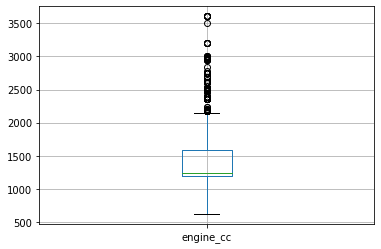

In [9]:
# Checking for Outliers
#engine_cc

col = 'engine_cc'
df.boxplot(column=col)

(array([ 677., 2421., 2744.,  427.,  426.,  476.,  589.,  134.,    5.,
           7.]),
 array([ 624.,  922., 1220., 1518., 1816., 2114., 2412., 2710., 3008.,
        3306., 3604.]),
 <BarContainer object of 10 artists>)

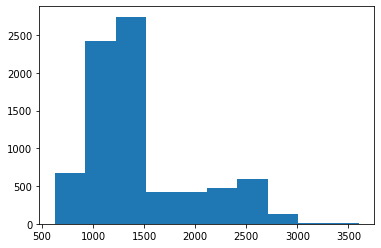

In [10]:
plot.hist(df[col])

The value of engine cc is by design, there are multiple cars with the highest value of cc i.e. 3604. 
Thus we can keep it as it is and not consider these as outliers

<AxesSubplot:>

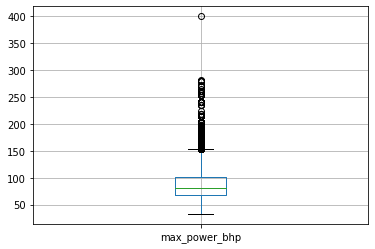

In [11]:
# Checking for Outliers
#max_power_bhp

col = 'max_power_bhp'
df.boxplot(column=col)

In [12]:
df[col].sort_values(ascending=False)

4078   400.00
25     282.00
4659   280.00
4059   280.00
6674   280.00
        ...  
162     34.20
2008    34.20
7091    34.20
7427    32.80
3393    32.80
Name: max_power_bhp, Length: 7906, dtype: float64

In [13]:
df[df[col]==400]

,Name,Selling_Price,km_Driven,Fuel,Seller_Type,Transmission,Owner,Seats,City_Name,company,engine_cc,max_power_bhp,sold,mileage_per100bucks,age
4078,Volvo XC90 T8 Excellence BSIV,10000000,30000.00,Petrol,Individual,Automatic,First Owner,4,Hyderabad,Volvo,1969,400.00,True,42.96,-3


Just one car with max_power_bhp = 400. This is an outlier among the dataset and can be replaced by mean value.

In [14]:
df[col] = np.where(df[col]==400,df[col].mean(),df[col])

<AxesSubplot:>

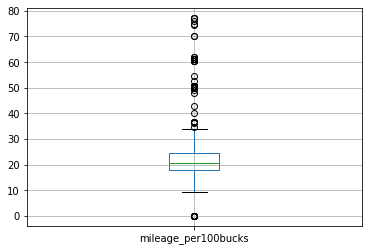

In [15]:
# Checking for Outliers
#mileage_per100bucks

col = 'mileage_per100bucks'
df.boxplot(column=col)

In [16]:
df[col].sort_values(ascending=True).head(18)

323    0.00
6423   0.00
4237   0.00
4573   0.00
1142   0.00
1956   0.00
3630   0.00
1296   0.00
6362   0.00
6023   0.00
5587   0.00
451    0.00
144    0.00
6544   0.00
1154   0.00
1276   0.00
7077   0.00
7675   9.21
Name: mileage_per100bucks, dtype: float64

There are 18 records where mileage_per100bucks is 0. This seems like a data not available error and thus can be replaced with mean values

In [17]:
df[col] = np.where(df[col]==0,df[col].mean(),df[col])

In [18]:
df[[col,'Fuel']].sort_values(by=col,ascending=False).head(30)

,mileage_per100bucks,Fuel
5369,77.05,CNG
4017,77.05,CNG
6623,77.05,CNG
6014,76.04,CNG
4824,74.93,CNG
1133,74.33,CNG
5402,70.18,CNG
1744,70.18,CNG
2794,61.82,CNG
6536,61.82,CNG


On the higher side values are more evenly spread out and that too are for CNG cars which are known to have high mileage per rupee. Thus, these shouldn't be considered as outliers.

In [19]:
# One Hot Encoding
col_to_be_encoded = ['Fuel','Seller_Type',
    'Transmission','Owner','Seats','City_Name',
    'company']

df = pd.get_dummies(df,columns=col_to_be_encoded)

#### Principal Component Analysis

1) Standardization
2) Covariance Matrix Computation
3) Compute Eigen Vectors and Eigen Values
4) Feature Vector

##### Step 1 Standardization

In [20]:
# Create x and y df
x = df.drop(columns=['Name','Selling_Price'])
y = df['Selling_Price']

In [21]:
sc = StandardScaler().fit(x)
standard_x = sc.transform(x)
x_scaled = pd.DataFrame(standard_x,columns=x.columns)
x_scaled.head()

,km_Driven,engine_cc,max_power_bhp,sold,mileage_per100bucks,age,Fuel_CNG,Fuel_Diesel,Fuel_LPG,Fuel_Petrol,...,company_Mercedes-Benz,company_Mitsubishi,company_Nissan,company_Opel,company_Renault,company_Skoda,company_Tata,company_Toyota,company_Volkswagen,company_Volvo
0,1.60,-0.42,-0.49,1.72,0.97,0.00,-0.08,0.92,-0.07,-0.90,...,-0.08,-0.04,-0.10,-0.01,-0.17,-0.12,-0.32,-0.25,-0.15,-0.09
1,-1.33,-1.32,-1.53,1.72,-0.91,-3.36,-0.08,-1.09,-0.07,1.12,...,-0.08,-0.04,-0.10,-0.01,-0.17,-0.12,-0.32,-0.25,-0.15,-0.09
2,0.44,-0.19,-0.69,1.72,1.00,-0.77,-0.08,0.92,-0.07,-0.90,...,-0.08,-0.04,-0.10,-0.01,-0.17,-0.12,-0.32,4.06,-0.15,-0.09
3,-0.33,-0.12,-0.04,1.72,0.88,-0.51,-0.08,0.92,-0.07,-0.90,...,-0.08,-0.04,-0.10,-0.01,-0.17,-0.12,-0.32,-0.25,-0.15,-0.09
4,0.24,-1.32,-1.27,1.72,-0.26,-3.10,-0.08,-1.09,-0.07,1.12,...,-0.08,-0.04,-0.10,-0.01,-0.17,-0.12,-0.32,-0.25,-0.15,-0.09


##### Step 2 Covariance Matrix Computation

In [22]:
cov_matrix = x_scaled.cov()
cov_matrix

,km_Driven,engine_cc,max_power_bhp,sold,mileage_per100bucks,age,Fuel_CNG,Fuel_Diesel,Fuel_LPG,Fuel_Petrol,...,company_Mercedes-Benz,company_Mitsubishi,company_Nissan,company_Opel,company_Renault,company_Skoda,company_Tata,company_Toyota,company_Volkswagen,company_Volvo
km_Driven,1.00,0.24,-0.05,-0.01,-0.09,-0.49,-0.01,0.32,0.03,-0.33,...,-0.03,0.06,0.01,0.01,-0.03,0.01,0.08,0.17,0.01,-0.11
engine_cc,0.24,1.00,0.71,0.01,-0.39,0.02,-0.06,0.51,-0.06,-0.49,...,0.14,0.07,-0.01,0.00,-0.10,0.04,0.03,0.38,-0.00,0.09
max_power_bhp,-0.05,0.71,1.00,0.01,-0.28,0.23,-0.07,0.31,-0.06,-0.29,...,0.22,0.04,-0.01,-0.00,-0.07,0.04,-0.02,0.16,0.02,0.21
sold,-0.01,0.01,0.01,1.00,-0.04,0.00,-0.02,-0.02,-0.01,0.03,...,0.01,-0.00,0.04,-0.01,-0.00,-0.02,-0.00,0.01,-0.02,0.01
mileage_per100bucks,-0.09,-0.39,-0.28,-0.04,1.00,0.27,0.50,0.21,0.16,-0.32,...,-0.08,-0.04,0.00,-0.02,0.07,-0.05,-0.03,-0.21,0.01,-0.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
company_Skoda,0.01,0.04,0.04,-0.02,-0.05,-0.01,-0.01,0.00,-0.01,-0.00,...,-0.01,-0.00,-0.01,-0.00,-0.02,1.00,-0.04,-0.03,-0.02,-0.01
company_Tata,0.08,0.03,-0.02,-0.00,-0.03,-0.06,-0.02,0.12,-0.02,-0.12,...,-0.03,-0.01,-0.03,-0.00,-0.05,-0.04,1.00,-0.08,-0.05,-0.03
company_Toyota,0.17,0.38,0.16,0.01,-0.21,-0.02,-0.02,0.10,-0.02,-0.09,...,-0.02,-0.01,-0.03,-0.00,-0.04,-0.03,-0.08,1.00,-0.04,-0.02
company_Volkswagen,0.01,-0.00,0.02,-0.02,0.01,0.00,-0.01,0.05,-0.01,-0.05,...,-0.01,-0.01,-0.02,-0.00,-0.03,-0.02,-0.05,-0.04,1.00,-0.01


In [25]:
# search for pairs with cov more than threshold
threshold = .6

for idx, each_row in cov_matrix.iterrows():
    for value_name, value in each_row.items():
        if (idx != value_name) & (value>threshold):
            print(idx,value_name,value)

engine_cc max_power_bhp 0.7062917703487235
max_power_bhp engine_cc 0.7062917703487235


In [29]:
pca = PCA()
x_pca = pca.fit_transform(x_scaled)
x_pca

array([[-9.86415417e-01,  4.30246302e-01,  1.65313049e+00, ...,
        -1.37353199e-15, -1.63675765e-15, -2.67439205e-16],
       [-3.23968515e+00,  1.06216948e+00, -3.69636482e+00, ...,
        -4.93993064e-14,  5.23287886e-15, -5.49674306e-15],
       [-3.43423687e-02,  8.13509215e-01,  8.69357447e-01, ...,
        -2.35934706e-15,  3.68212127e-15,  1.17231787e-15],
       ...,
       [-9.38711392e-01,  1.59899916e+00, -4.22263009e-02, ...,
         1.04713329e-16, -4.74901169e-17, -1.60128328e-17],
       [ 4.80265308e+00, -4.37440814e+00, -2.15375943e+00, ...,
        -8.94056968e-16,  2.23539905e-18,  2.61829095e-17],
       [-1.85223186e+00, -1.22157733e+00, -6.34791400e-04, ...,
         1.49787448e-17,  4.84661164e-16,  4.29108157e-17]])

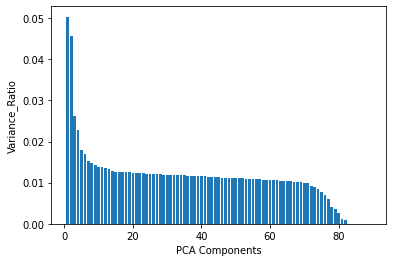

In [30]:
ax = plot.bar(range(1,len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_)
plot.xlabel("PCA Components")
plot.ylabel("Variance_Ratio")
plot.show()

In [46]:
col=[i+1 for i in range(x_pca.shape[1])]
x = np.cumsum(pca.explained_variance_ratio_*100)
variance_df = pd.DataFrame({'PC':col,
    'EV':pca.explained_variance_ratio_ * 100,
    'Cumulative EV': x})
pd.set_option("display.max_rows", None, "display.max_columns", None)
variance_df


,PC,EV,Cumulative EV
0,1,5.03,5.03
1,2,4.58,9.61
2,3,2.61,12.22
3,4,2.28,14.50
4,5,1.80,16.30
5,6,1.69,17.99
6,7,1.53,19.52
7,8,1.48,21.00
8,9,1.42,22.42
9,10,1.39,23.80


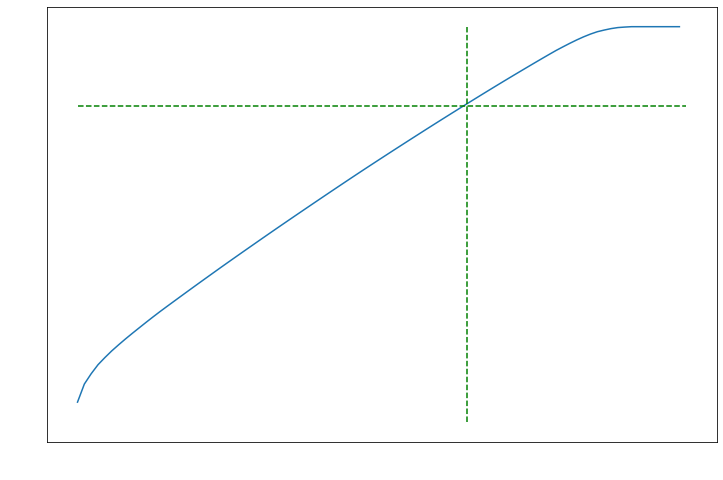

In [52]:
y_line = 80
x_line = variance_df[variance_df['Cumulative EV']<=y_line].tail(1)['PC'].iloc[0]
fig = plot.figure(figsize=(12,8))
plot.plot(x)
plot.hlines(y=y_line,xmax=x.shape[0],xmin=0,color='g',linestyles='--')
plot.vlines(x=x_line,ymax=100,ymin=0,color='g',linestyles='--')
plot.xlabel("Number of PCA components",color='w')
plot.ylabel("Cumulative Explained Variance",color='w')
plot.tick_params(axis='x', colors='w')
plot.tick_params(axis='y', colors='w')
